In [0]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task A','ID'],axis=1)
  df=df[(df['Sub-task B']=="NGEN")|(df['Sub-task B']=='GEN')].dropna()
  df['Sub-task B'] = df['Sub-task B'].map({'NGEN': 0, 'GEN': 1})
  return df

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_df=load_csv("/content/drive/My Drive/Colab Notebooks/hin_train.csv")
dev_df=load_csv("/content/drive/My Drive/Colab Notebooks/hin_dev.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task B
0  Bollywood film dekhne ke samay logic ghar mein...           0
1                                   Chutiya movie...           0
2  Us jaat bnde ka khene ka matlab tha mar daluga...           0
3  @Feminism Is CANCER *un feminist yeh sahi hai ...           0
4       Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने           0
                                                Text  Sub-task B
0  bkl interviewers kuch jaada hi open minded bnt...           0
1  Bhaiya shaadi mein zaroor aana movie ka plot j...           0
2  Section 375 hai kya??? .... Ye to batate kam s...           0
3  कबीर सिंह hit Hui इससे पता चलता है आजकल के लोग...           0
4             Maine itni kam dislike kbhi nhii dekhi           0


In [0]:
train_df.shape,dev_df.shape

((3984, 2), (997, 2))

In [0]:
print(train_df['Sub-task B'].value_counts())
print(dev_df['Sub-task B'].value_counts())

0    3323
1     661
Name: Sub-task B, dtype: int64
0    845
1    152
Name: Sub-task B, dtype: int64


In [0]:
from keras.preprocessing.text import one_hot
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in train_df['Text']]
print (encoded_docs)
encoded_docs2=[one_hot(d,vocab_size) for d in dev_df['Text']]
print (encoded_docs2)

[[975058, 3147613, 2117651, 764438, 965573, 404339, 3984965, 2563084, 2267726, 1145844, 1623822, 451234, 3367774, 404339, 2604896, 3156769], [468434, 2552717], [178828, 912201, 1145346, 2970433, 1931327, 2970433, 3053902, 803804, 2571888, 3623151, 1627425, 1534121, 1143907, 3772196, 3514936, 613170, 3358737, 764438, 468434, 1164073, 1861233, 671544, 1215737, 2251340, 3844830, 1923404, 715336, 66130, 1227955, 942585, 2658459, 1871494, 1215737, 1871494, 473654, 3409015, 1534121, 569444, 1871494, 1026778, 619602, 541798, 3409015, 2803541, 2984334, 1115710, 707515, 1164073, 1025385, 3656498, 3665385, 1180017, 2704971, 1448463, 1716187, 1923404, 715336, 468434, 2859032], [1388678, 2485312, 2432622, 112399, 1701089, 2698495, 2777496, 715336, 1534121, 1424363, 3053902, 942585, 3059145, 9670, 715336, 2803541, 1529800, 493803, 1532522, 1376837, 346590, 1419199, 1294159, 2453340, 1758036, 546291, 3998196, 1311543, 21762, 2921113, 671544, 3678221, 1812678, 2842109, 2141203, 739458, 174254], [1508

In [0]:
# pad documents to a max length of 4 words
max_length = 100
X_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(X_train)
X_test = pad_sequences(encoded_docs2, maxlen=max_length, padding='post')
print(X_test)

[[3474391 1485986 2945297 ...       0       0       0]
 [2013276 1494869       0 ...       0       0       0]
 [3645315 1255747 2091308 ...       0       0       0]
 ...
 [ 457375 2041274 1241900 ...       0       0       0]
 [3959709 2149043  168702 ...       0       0       0]
 [2078599  434852 1927682 ...       0       0       0]]
[[ 415169 2715765 3959709 ...       0       0       0]
 [3466751 3052982 1447321 ...       0       0       0]
 [2723935  693116 1241900 ...       0       0       0]
 ...
 [1650632 3586036 3562105 ...       0       0       0]
 [3516955 2371555 3609762 ...       0       0       0]
 [3259057 1838697 1390422 ...       0       0       0]]


In [0]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Sub-task B']))
y_test = to_categorical(np.asarray(dev_df['Sub-task B']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(3984, 2) (997, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 8)            32000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 128)           3200      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               622848    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [0]:
history=model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=100,batch_size=100, verbose=2)

Train on 3984 samples, validate on 997 samples
Epoch 1/100
 - 2s - loss: 0.4770 - acc: 0.8281 - val_loss: 0.4242 - val_acc: 0.8475
Epoch 2/100
 - 1s - loss: 0.4389 - acc: 0.8341 - val_loss: 0.4183 - val_acc: 0.8475
Epoch 3/100
 - 1s - loss: 0.3917 - acc: 0.8341 - val_loss: 0.4034 - val_acc: 0.8475
Epoch 4/100
 - 1s - loss: 0.2949 - acc: 0.8368 - val_loss: 0.4469 - val_acc: 0.8475
Epoch 5/100
 - 1s - loss: 0.2004 - acc: 0.8943 - val_loss: 0.5209 - val_acc: 0.8445
Epoch 6/100
 - 1s - loss: 0.1458 - acc: 0.9561 - val_loss: 0.6174 - val_acc: 0.8375
Epoch 7/100
 - 1s - loss: 0.1065 - acc: 0.9724 - val_loss: 0.7401 - val_acc: 0.8305
Epoch 8/100
 - 1s - loss: 0.0792 - acc: 0.9809 - val_loss: 0.7906 - val_acc: 0.8054
Epoch 9/100
 - 1s - loss: 0.0584 - acc: 0.9857 - val_loss: 0.9200 - val_acc: 0.8235
Epoch 10/100
 - 1s - loss: 0.0488 - acc: 0.9902 - val_loss: 0.9713 - val_acc: 0.7974
Epoch 11/100
 - 1s - loss: 0.0445 - acc: 0.9917 - val_loss: 1.0677 - val_acc: 0.7964
Epoch 12/100
 - 1s - loss: 

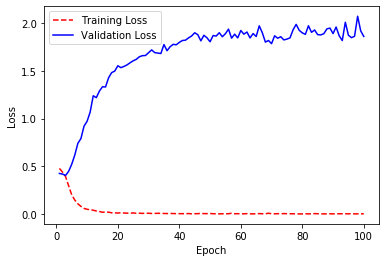

In [0]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

[1.8600534510795483, 0.8094282848545636]


In [0]:
predictions_test = model.predict(X_test)
print(predictions_test)

[[1.00000000e+00 1.81473054e-20]
 [1.00000000e+00 1.69864297e-25]
 [1.00000000e+00 1.31737024e-17]
 ...
 [9.99999404e-01 6.08193147e-07]
 [9.99999881e-01 8.43643946e-08]
 [9.93437350e-01 6.56257942e-03]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       845
           1       0.34      0.27      0.30       152

   micro avg       0.81      0.81      0.81       997
   macro avg       0.61      0.59      0.60       997
weighted avg       0.79      0.81      0.80       997
 samples avg       0.81      0.81      0.81       997



In [0]:
predicting_df = pd.read_csv("/content/drive/My Drive/Minor Project/hin_test.csv")
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in predicting_df['Text']]
max_length = 100
test_df = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
predictions_test = model.predict(test_df)
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1
predictions_test1 = predictions_test1.argmax(1)
predictions_test1 = pd.Series(predictions_test1)
predictions_test1 = predictions_test1.rename("Label")
ps = predicting_df['ID']
output_df = pd.merge(ps,predictions_test1,how='outer',left_index=True,right_index=True)
output_df['Label'] = output_df['Label'].map({0: 'NGEN',1: 'GEN'})
output_df.head()

ID Label
0  C52.17   GEN
1  C52.39  NGEN
2  C52.73  NGEN
3   C60.3  NGEN
4  C60.43  NGEN

In [0]:
output_df.to_csv("Hindi_TaskB_Run1_CNN_Onehot.csv")